In [1]:
%pip install -q PyAthena[SQLAlchemy]

Note: you may need to restart the kernel to use updated packages.


## Prepare Datasets for Predictor Training, Validation and Testing

#### TS

Import modules that build patient cohort, extract demographics and lab events data:

In [1]:
from dataproc.cohort import query_esbl_pts, remove_dups, observation_window
from dataproc.sampling import generate_samples
from dataproc.create_dataset import dataset_creation
from hyper_params import HyperParams

import numpy as np
import pandas as pd
from pandas import DataFrame
from matplotlib import pyplot
%matplotlib inline

from sklearn.preprocessing import OneHotEncoder

In [2]:
pd.__version__

'1.1.5'

In [3]:
# load hyperparams instance
params = HyperParams()

Patients cohort:

In [3]:
# Select esbl microbiology test
esbl_admits = query_esbl_pts()
# Remove dups
esbl_admits = remove_dups(esbl_admits)
# Create observation window
esbl_admits_window = observation_window(esbl_admits, window_size=params.observation_window_hours)
# Subset columns
pts_labels = esbl_admits_window[['hadm_id', 'index_date','RESISTANT_YN']]
pts_labels.to_pickle('data/patient_labels.pkl')

Import cohort/labels data from the .pkl file:

In [4]:
pts_labels = pd.read_pickle('data/patient_labels.pkl')
print(pts_labels.shape)
pts_labels.head()

(4636, 3)


,hadm_id,index_date,RESISTANT_YN
7010,101757,2132-12-31 16:30:00,0
7015,186474,2155-02-25 18:45:00,0
7016,194730,2170-12-22 06:12:00,0
7017,112086,2147-04-05 14:00:00,0
7018,158569,2142-04-01 18:34:00,1


Patient's features data:

In [ ]:
# Loading the features
features = dataset_creation(pts_labels['hadm_id'], params.observation_window_hours)
features = features.merge(pts_labels[['hadm_id','RESISTANT_YN']], on='hadm_id')
features.to_pickle('data/features.pkl')

Import features data from the .pkl file:

In [5]:
features = pd.read_pickle('data/features.pkl')
print(list(features.columns))

['hadm_id', 'subject_id', '10378-8', '10535-3', '10839-9', '11555-0', '11556-8', '11557-6', '11558-4', '13362-9', '1644-4', '1742-6', '1751-7', '17849-1', '1798-8', '1863-0', '1920-8', '1959-6', '1963-8', '1968-7', '1971-1', '1975-2', '1988-5', '1994-3', '19991-9', '19994-3', '2000-8', '20077-4', '20112-9', '20564-1', '20569-0', '20570-8', '20578-1', '2069-3', '2075-0', '2078-4', '2085-9', '2090-9', '2093-3', '2143-6', '2157-6', '2160-0', '2161-8', '2170-9', '2276-4', '2284-8', '2339-0', '2345-7', '2498-4', '2500-7', '2532-0', '2601-3', '26498-6', '2692-2', '2695-5', '2777-1', '2823-3', '2828-2', '28541-1', '2947-0', '2951-2', '2955-3', '30089-7', '3016-3', '30226-5', '3040-3', '3094-0', '3095-7', '3151-8', '3173-2', '3255-7', '32693-4', '3297-9', '3349-8', '3376-1', '33762-6', '3377-9', '3390-2', '33914-3', '3397-7', '34728-6', '3773-9', '3879-4', '3967-7', '4023-8', '4073-3', '42662-7', '4542-7', '4544-3', '4548-4', '48065-7', '5642-4', '5767-9', '5769-5', '5770-3', '5778-6', '5787-7

In [6]:
loinc_codes = list(features.drop(columns=['hadm_id', 'subject_id', 'admittime','admission_type']).columns)[:-9]
print(list(loinc_codes))

['10378-8', '10535-3', '10839-9', '11555-0', '11556-8', '11557-6', '11558-4', '13362-9', '1644-4', '1742-6', '1751-7', '17849-1', '1798-8', '1863-0', '1920-8', '1959-6', '1963-8', '1968-7', '1971-1', '1975-2', '1988-5', '1994-3', '19991-9', '19994-3', '2000-8', '20077-4', '20112-9', '20564-1', '20569-0', '20570-8', '20578-1', '2069-3', '2075-0', '2078-4', '2085-9', '2090-9', '2093-3', '2143-6', '2157-6', '2160-0', '2161-8', '2170-9', '2276-4', '2284-8', '2339-0', '2345-7', '2498-4', '2500-7', '2532-0', '2601-3', '26498-6', '2692-2', '2695-5', '2777-1', '2823-3', '2828-2', '28541-1', '2947-0', '2951-2', '2955-3', '30089-7', '3016-3', '30226-5', '3040-3', '3094-0', '3095-7', '3151-8', '3173-2', '3255-7', '32693-4', '3297-9', '3349-8', '3376-1', '33762-6', '3377-9', '3390-2', '33914-3', '3397-7', '34728-6', '3773-9', '3879-4', '3967-7', '4023-8', '4073-3', '42662-7', '4542-7', '4544-3', '4548-4', '48065-7', '5642-4', '5767-9', '5769-5', '5770-3', '5778-6', '5787-7', '5792-7', '5793-5', '5

In [7]:
features_summary = features[loinc_codes].describe()

In [9]:
# Embedding the features
from dataproc.embeddings import loinc_values

loinc_vals = loinc_values(loinc_codes)
loinc_vals.to_pickle('data/loinc_vals_raw.pic')
loinc_vals.shape
# loinc_vals.set_index('loinc_code')

,value
loinc_code,
42662-7,NEG
2160-0,3.6
3040-3,27
5895-7,1.1
785-6,28.8
...,...
2160-0,0.8
2601-3,1.8
2777-1,3.6


In [12]:
loinc_vals.dropna(subset=['value'], inplace=True)
loinc_vals = loinc_vals.astype({'value': 'string', 'loinc_code': 'category'})
loinc_vals['value'] = loinc_vals['value'].map(lambda x: x.lstrip('LESS THAN '))
loinc_vals['value'] = loinc_vals['value'].map(lambda x: x.lstrip('GREATER THAN '))
loinc_vals['value'] = loinc_vals['value'].map(lambda x: x.lstrip('>GREATER THAN '))
loinc_vals['value'] = loinc_vals['value'].map(lambda x: x.lstrip('<LESS THAN '))
loinc_vals['value'] = loinc_vals['value'].map(lambda x: x.rstrip(' NG/ML'))
loinc_vals['value'] = loinc_vals['value'].map(lambda x: x.lstrip('<>'))
loinc_vals['value'] = loinc_vals['value'].map(lambda x: x.replace(',', '.'))
loinc_vals.to_pickle('data/loinc_vals_str_clean.pic')

In [59]:
if loinc_vals is None:
    loinc_vals = pd.read_pickle('data/loinc_vals_str_clean.pic')

In [13]:
loinc_vals.drop(list(loinc_vals.loc[loinc_vals['value'] == 'UNABLE TO ANALYZE'].index),  inplace=True)
loinc_vals.drop(list(loinc_vals.loc[loinc_vals['value'] == 'MOLYSIS FALSELY DECREASES THIS RESULT'].index),  inplace=True)
loinc_vals.drop(list(loinc_vals.loc[loinc_vals['value'] == 'COMPUTER NETWORK FAILURE. TEST NOT RESULTED.'].index),  inplace=True)
loinc_vals.drop(list(loinc_vals.loc[loinc_vals['value'] == 'UNABLE TO DETERMINE'].index),  inplace=True)
loinc_vals.drop(list(loinc_vals.loc[loinc_vals['value'] == ':UNABLE TO DETERMINE'].index),  inplace=True)
loinc_vals.drop(list(loinc_vals.loc[loinc_vals['value'] == 'UNABLE TO QUANTITATE'].index),  inplace=True)
loinc_vals.drop(list(loinc_vals.loc[loinc_vals['value'] == 'UNABLE TO REPORT'].index),  inplace=True)
loinc_vals.to_pickle('data/loinc_vals.pic')

In [8]:
loinc_vals = pd.read_pickle('data/loinc_vals.pic')

In [11]:
numeric = []
categorical = []
weird = []
for code in loinc_codes:
    size = len(loinc_vals.loc[loinc_vals['loinc_code'] == str(code), 'value'])
    size_unique = len(loinc_vals.loc[loinc_vals['loinc_code'] == str(code), 'value'].unique())
    sum_na = pd.to_numeric(loinc_vals.loc[loinc_vals['loinc_code'] == str(code), 'value'], errors='coerce').isna().sum()
    if sum_na / size < 0.05:
        numeric.append(code)
    elif sum_na / size > 0.05 and size_unique < 100:
        categorical.append(code)
    else:
        weird.append(code)

In [12]:
numeric.append('age')

In [13]:
# remove lab column that contains only 'inf' and 'Nan'
numeric.remove('26498-6')
# remove lab column that contains phrase 'See comments'
categorical.remove('33914-3')
# remove lab column that contains phrase 'Random'
categorical.remove('13362-9')

In [14]:
print('All:', len(loinc_codes))
print('Numeric: ', len(numeric))
print('Categorical: ', len(categorical))
print('Weird:', len(weird))

All: 144
Numeric:  95
Categorical:  36
Weird: 11


In [110]:
numeric = ['age','10535-3','11555-0','11556-8','11557-6','11558-4','1644-4','1742-6','1751-7','17849-1','1798-8','1863-0','1920-8','1959-6','1963-8','1968-7','1971-1','1975-2','1988-5','1994-3','19991-9','19994-3','2000-8','20077-4','20112-9','20564-1','20569-0','20570-8','20578-1','2069-3','2075-0','2078-4','2085-9','2090-9','2093-3','2143-6','2157-6','2160-0','2161-8','2170-9','2276-4','2284-8','2339-0','2345-7','2498-4','2500-7','2532-0','2601-3','2692-2','2695-5','2777-1','2823-3','2828-2','28541-1','2947-0','2951-2','2955-3','3016-3','3040-3','3094-0','3095-7','3151-8','3173-2','3255-7','32693-4','33762-6','34728-6','3967-7','4544-3','5803-2','5811-5','5895-7','5902-2','6298-4','6768-6','704-7','711-2','718-7','731-0','733-6','742-7','761-7','763-3','772-4','777-3','785-6','786-4','787-2','788-0','789-8','804-5','9322-9']
categorical = ['10378-8','30089-7','30226-5','3349-8','3376-1','3377-9','3390-2','3397-7','3773-9','3879-4','4073-3','42662-7','5767-9','5769-5','5770-3','5778-6','5792-7','5794-3','5797-6','5799-2','5802-4','5804-0','5818-0','5822-2','702-1','728-6','738-5','741-9','774-0','778-1','779-9','7790-9','7791-7','800-3','8246-1','8247-9']
weird = ['10839-9','3297-9','4023-8','4542-7','4548-4','48065-7','5642-4','5787-7','5793-5','5796-8','5808-1','5821-4','6598-7','6773-6']               

Summary statistics for numeric lab codes:

In [15]:
numeric_stats = []
for code in numeric:
    a = pd.to_numeric(loinc_vals.loc[loinc_vals['loinc_code'] == str(code), 'value'], errors='coerce').describe(percentiles=[.01,.25, .5, .75, .95, .99])
    numeric_stats.append(a)
numeric_stats_df = pd.concat(numeric_stats, axis=1, keys=numeric)
numeric_stats_df['age'] = features['age'].describe(percentiles=[.01,.25, .5, .75, .95, .99])

In [16]:
numeric_stats_df

,10535-3,10839-9,11555-0,11556-8,11557-6,11558-4,1644-4,1742-6,1751-7,17849-1,...,772-4,777-3,785-6,786-4,787-2,788-0,789-8,804-5,9322-9,age
count,8358.000000,11447.000000,490527.000000,490523.000000,490504.000000,530658.000000,24986.000000,219448.000000,146690.000000,10073.000000,...,16564.000000,778241.000000,747560.000000,747921.000000,747537.000000,746408.000000,747568.000000,753127.000000,18128.000000,4328.000000
mean,1.129834,7.479856,-0.090604,136.737019,42.736738,7.379366,167.710318,129.960002,3.178038,2.534686,...,13.766542,239.295564,30.220467,33.508648,90.264973,15.799282,3.510249,10.499787,3.920383,73.722736
std,0.749934,16.189266,5.353903,92.114782,11.388981,0.087115,229.124373,536.810586,0.757973,1.775861,...,59.786263,150.321123,2.574024,1.573992,6.987865,2.356128,0.656843,9.006713,2.365156,50.886496
min,0.020000,0.000000,-414.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.900000,0.000000,...,0.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.800000,0.000000
1%,0.200000,0.300000,-14.000000,31.000000,24.000000,7.110000,34.000000,5.000000,1.600000,0.200000,...,1.000000,17.000000,23.000000,29.500000,74.000000,12.300000,2.240000,0.600000,1.700000,0.000000
25%,0.600000,0.300000,-3.000000,81.000000,36.000000,7.330000,85.000000,18.000000,2.600000,1.400000,...,1.000000,139.000000,28.900000,32.500000,86.000000,14.100000,3.050000,6.400000,2.800000,55.000000
50%,1.000000,0.400000,0.000000,109.000000,41.000000,7.390000,124.000000,32.000000,3.100000,2.100000,...,3.000000,215.000000,30.300000,33.600000,90.000000,15.300000,3.440000,9.100000,3.500000,68.000000
75%,1.400000,4.700000,3.000000,156.000000,47.000000,7.440000,187.000000,69.000000,3.700000,3.200000,...,8.000000,307.000000,31.600000,34.600000,94.000000,17.000000,3.900000,12.800000,4.500000,78.000000
95%,2.500000,50.000000,8.000000,358.000000,63.000000,7.500000,387.000000,391.000000,4.400000,6.000000,...,46.000000,515.000000,34.300000,36.000000,102.000000,20.300000,4.700000,21.400000,6.600000,88.000000
99%,3.900000,50.000000,13.000000,463.000000,83.000000,7.540000,835.150000,2208.000000,4.800000,8.700000,...,210.000000,739.000000,37.200000,37.000000,111.000000,23.400000,5.290000,33.500000,11.600000,300.000000


In [140]:
weird = ['3297-9',
 '4023-8',
 '4548-4',
 '48065-7',
 '5642-4',
 '5787-7',
 '5793-5',
 '5796-8',
 '5808-1',
 '5821-4',
 '6773-6']

In [17]:
loinc_codes = list(set(loinc_codes) - set(weird))

In [18]:
# for now, ignoring the mixed type lab tests
dataset = features.drop(columns=weird, errors='ignore')

In [19]:
dataset.shape

(4328, 146)

### Data Preprocessing  and Embeddings:

In [20]:
print(list(dataset.columns))

['hadm_id', 'subject_id', '10378-8', '10535-3', '10839-9', '11555-0', '11556-8', '11557-6', '11558-4', '13362-9', '1644-4', '1742-6', '1751-7', '17849-1', '1798-8', '1863-0', '1920-8', '1959-6', '1963-8', '1968-7', '1971-1', '1975-2', '1988-5', '1994-3', '19991-9', '19994-3', '2000-8', '20077-4', '20112-9', '20564-1', '20569-0', '20570-8', '20578-1', '2069-3', '2075-0', '2078-4', '2085-9', '2090-9', '2093-3', '2143-6', '2157-6', '2160-0', '2161-8', '2170-9', '2276-4', '2284-8', '2339-0', '2345-7', '2498-4', '2500-7', '2532-0', '2601-3', '26498-6', '2692-2', '2695-5', '2777-1', '2823-3', '2828-2', '28541-1', '2947-0', '2951-2', '2955-3', '30089-7', '3016-3', '30226-5', '3040-3', '3094-0', '3095-7', '3151-8', '3173-2', '3255-7', '32693-4', '3349-8', '3376-1', '33762-6', '3377-9', '3390-2', '33914-3', '3397-7', '34728-6', '3773-9', '3879-4', '3967-7', '4073-3', '42662-7', '4542-7', '4544-3', '5767-9', '5769-5', '5770-3', '5778-6', '5792-7', '5794-3', '5797-6', '5799-2', '5802-4', '5803-2'

#### Remove rare lab tests

In [21]:
missing_values_counts_for_labtests = dataset[loinc_codes].isna().sum()

<AxesSubplot:>

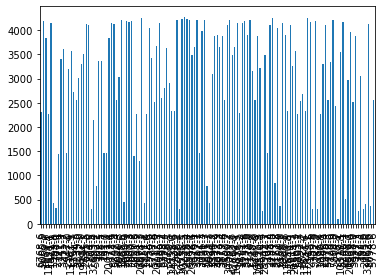

In [22]:
missing_values_counts_for_labtests.plot.bar()

In [23]:
# percent of columns with rare values
max_missing_vals = 0.9 * dataset.shape[0]
np.mean(missing_values_counts_for_labtests > max_missing_vals)

0.3007518796992481

In [24]:
max_missing_vals = 0.9 * dataset.shape[0]
rare_labtests = missing_values_counts_for_labtests[missing_values_counts_for_labtests > max_missing_vals].index.tolist()

In [25]:
# drop the rare labtests from the dataset
dataset = dataset.drop(columns=rare_labtests)

In [27]:
# update the column names lists
numeric = list(set(numeric) - set(rare_labtests))
categorical = list(set(categorical) - set(rare_labtests))

#### Clean lab numeric variables:

In [28]:
# Convert to numeric selected columns
dataset[numeric] = dataset[numeric].apply(pd.to_numeric, errors='coerce', axis=1)

Since many lab data have outliers the median and interquartile range can be used to standardizing the numeric variables:   
- value = (value – median) / (p75 – p25)

In [29]:
def stanardize_numeric_values(df, list_of_clms, ref_df):
    """
    Use the median and interquartile range to 
    standardize the numeric variables
    value = (value – median) / (p75 – p25)
    """
    for code in list_of_clms:
        median = ref_df[code]['50%']
        p25 = ref_df[code]['1%']
        p75 = ref_df[code]['99%']
        df[code] = (df[code] - median) / (p75 - p25)
    return df

def handle_extreme_numeric_values(df, list_of_clms, ref_df):
    """
    clean extreme values outside pct 1-99
    """
    for code in list_of_clms:
        if code == 'age':
            thresh = 105 # invented a believable max age 
            df[code] = df[code].apply(lambda x: x if x < thresh else np.nan)
        else:
            thresh = 4 * ref_df[code]['std']
            df[code] = df[code].apply(lambda x: x if x < thresh else np.nan)
        
#         df[code] = np.maximum(df[code], p01)
    return df
    

In [30]:
dataset = handle_extreme_numeric_values(dataset, numeric, numeric_stats_df)

In [ ]:
dataset

In [45]:
def bin_numerics(dataset: DataFrame, numeric_columns:list, bins=6, labels=False):
        df = dataset.copy(deep=True)
        df[numeric_columns] = df[numeric_columns].apply(lambda x: pd.cut(x, bins=min(x.nunique(), 6), labels=False) if x.nunique() > 0  else x)
#         df[numeric_columns].fillna(value=-1, inplace=True)
        for col in numeric_columns:
                df[col] = df[col].astype('str')

        return df

In [37]:
dataset[numeric].apply(lambda x: pd.cut(x, bins=min(x.nunique(), 6), labels=False).astype('str') if x.nunique() > 0 else x.astype('str')).head()

,10535-3,10839-9,11555-0,11556-8,11557-6,11558-4,1644-4,1742-6,1751-7,17849-1,...,772-4,777-3,785-6,786-4,787-2,788-0,789-8,804-5,9322-9,age
0,nan,nan,nan,nan,nan,nan,nan,0.0,nan,nan,...,nan,0.0,nan,nan,nan,nan,nan,1.0,nan,3.0
1,nan,nan,nan,nan,nan,nan,nan,0.0,nan,nan,...,nan,1.0,nan,nan,nan,nan,nan,1.0,nan,4.0
2,nan,nan,nan,nan,nan,nan,nan,0.0,nan,nan,...,nan,2.0,nan,nan,nan,nan,nan,1.0,nan,4.0
3,nan,nan,2.0,1.0,3.0,nan,nan,0.0,nan,nan,...,nan,1.0,nan,nan,nan,nan,nan,2.0,nan,3.0
4,nan,nan,nan,nan,nan,nan,nan,0.0,nan,nan,...,nan,2.0,nan,nan,nan,nan,nan,1.0,nan,5.0


In [58]:
dataset[numeric].head().fillna(value='Unknown')  #.apply(lambda x: pd.cut(x, bins=6, labels=False).astype('str')).head()

,10535-3,10839-9,11555-0,11556-8,11557-6,11558-4,1644-4,1742-6,1751-7,17849-1,...,772-4,777-3,785-6,786-4,787-2,788-0,789-8,804-5,9322-9,age
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,41.0,NaN,NaN,...,NaN,85.0,NaN,NaN,NaN,NaN,NaN,7.4,NaN,54.0
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15.0,NaN,NaN,...,NaN,149.0,NaN,NaN,NaN,NaN,NaN,9.5,NaN,69.0
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,23.0,NaN,NaN,...,NaN,210.0,NaN,NaN,NaN,NaN,NaN,6.3,NaN,69.0
3,NaN,NaN,-8.0,119.0,30.0,NaN,NaN,53.0,NaN,NaN,...,NaN,143.0,NaN,NaN,NaN,NaN,NaN,12.1,NaN,56.0
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,55.0,NaN,NaN,...,NaN,239.0,NaN,NaN,NaN,NaN,NaN,8.6,NaN,85.0


In [84]:
dataset = bin_numerics(dataset, numeric)
categorical = categorical + numeric

In [31]:
dataset = stanardize_numeric_values(dataset, numeric, numeric_stats_df)

Imputation of missing values using scikit-learn https://scikit-learn.org/stable/modules/impute.html#impute

In [32]:
from sklearn.impute import SimpleImputer

def replace_missing_val(df, list_of_clms, how='median', fill_value=0):
    """
    Imputation of missing values using median
    """
    if how == 'constant':
        imp = SimpleImputer(strategy=how, fill_value=fill_value)
    else:
        imp = SimpleImputer(strategy=how)
    
    df_prc = imp.fit_transform(df[list_of_clms])
    #df[list_of_clms] = pd.DataFrame(df_prc, columns=list_of_clms)
    return df_prc


In [33]:
numlabvars = dataset[numeric]

In [34]:
numlabvars = replace_missing_val(dataset, numeric, how='median')
# numlabvars = replace_missing_val(dataset, numeric, how='constant', fill_value=np.NINF)

In [35]:
numlabvars.shape

(4328, 52)

#### Clean lab categorical variables:

In [36]:
# dataset['30089-7'] = np.where(dataset['30089-7'].isin(['<1','1','2']), '0-2',
#                      np.where(dataset['30089-7'].isin(['3','4']),'3-5', dataset['30089-7']))

dataset['5767-9'] = np.where(dataset['5767-9'].isin(['CLEAR']), 'Clear',
                    np.where(dataset['5767-9'].isin(['SLHAZY']), 'SlHazy',
                    np.where(dataset['5767-9'].isin(['HAZY']), 'Hazy',
                    np.where(dataset['5767-9'].isin(['SlCloudy']),'SlCldy',  
                    np.where(dataset['5767-9'].isin(['CLOUDY']),'Cloudy',dataset['5767-9'])))))

dataset['5769-5'] = np.where(dataset['5769-5'].isin(['0']), 'NEG',
                    np.where(dataset['5769-5'].isin(['NOTDONE']), 'NONE',
                    np.where(dataset['5769-5'].isin(['LRG']), 'MANY', dataset['5769-5'])))

dataset['5778-6'] = np.where(dataset['5778-6'].isin(['YELLOW','YEL']), 'Yellow',
                    np.where(dataset['5778-6'].isin(['STRAW']), 'Straw',
                    np.where(dataset['5778-6'].isin(['AMBER','AMB']), 'Amber', 
                    np.where(dataset['5778-6'].isin(['RED']), 'Red', 
                    np.where(dataset['5778-6'].isin(['ORANGE']), 'Orange', 
                    np.where(dataset['5778-6'].isin(['DKAMB','DKAMBER']), 'DkAmb', 
                    np.where(dataset['5778-6'].isin([' ']), np.nan, dataset['5778-6'])))))))

dataset['5797-6'] = np.where(dataset['5797-6'].isin(['>80']), '80',dataset['5797-6'])

dataset['5804-0'] = np.where(dataset['5804-0'].isin(['>300']), '300',
                    np.where(dataset['5804-0'].isin([' ']), np.nan, dataset['5804-0']))

dataset['5818-0'] = np.where(dataset['5818-0'].isin(['.2']), '0.2',
                    np.where(dataset['5818-0'].isin(['>8','>8.0']), '8',
                    np.where(dataset['5818-0'].isin(['>12']), '12',
                    np.where(dataset['5818-0'].isin(['NotDone']), np.nan, dataset['5818-0']))))

dataset['5822-2'] = np.where(dataset['5822-2'].isin(['0', 'N']), 'NONE',
                    np.where(dataset['5822-2'].isin(['NOTDONE']), np.nan, dataset['5822-2']))

dataset['778-1'] = np.where(dataset['778-1'].isin(['UNABLE TO ESTIMATE DUE TO PLATELET CLUMPS']), 'NOTDETECTED', dataset['778-1'])


In [37]:
# print value counts for each lab categorical variable:
for col in categorical:
    print('----------------------------------')
    print('Column name: ', col)
    print(dataset[col].value_counts())

----------------------------------
Column name:  5802-4
NEG    1644
POS     120
Name: 5802-4, dtype: int64
----------------------------------
Column name:  3390-2
NEG    337
POS    102
Name: 3390-2, dtype: int64
----------------------------------
Column name:  3377-9
NEG    427
POS     11
Name: 3377-9, dtype: int64
----------------------------------
Column name:  4073-3
NEG    661
POS      5
Name: 4073-3, dtype: int64
----------------------------------
Column name:  741-9
NORMAL        608
1+            190
OCCASIONAL     56
2+             50
3+             18
Name: 741-9, dtype: int64
----------------------------------
Column name:  3879-4
NEG    367
POS     72
Name: 3879-4, dtype: int64
----------------------------------
Column name:  42662-7
NEG    652
POS     18
Name: 42662-7, dtype: int64
----------------------------------
Column name:  5770-3
NEG    1532
SM      178
MOD      29
LG       25
Name: 5770-3, dtype: int64
----------------------------------
Column name:  3773-9
NEG    4

In [38]:
# replace 'Nan' values in categorical variables by 'UNKNOWN'
dataset.update(dataset[categorical].fillna('UNKNOWN'))

In [39]:
dataset[categorical].head()

,5802-4,3390-2,3377-9,4073-3,741-9,3879-4,42662-7,5770-3,3773-9,728-6,...,5769-5,5818-0,3397-7,3349-8,702-1,738-5,3376-1,5792-7,5822-2,5778-6
0,NEG,NEG,NEG,NEG,UNKNOWN,POS,NEG,NEG,NEG,UNKNOWN,...,RARE,8,POS,NEG,UNKNOWN,UNKNOWN,NEG,100,NONE,Amber
1,UNKNOWN,UNKNOWN,UNKNOWN,NEG,2+,UNKNOWN,NEG,UNKNOWN,UNKNOWN,2+,...,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN,2+,2+,NEG,UNKNOWN,UNKNOWN,UNKNOWN
2,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN,...,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN
3,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN,1+,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN,...,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN,2+,1+,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN
4,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN,...,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN


Use one hot encoder for categoric lab features:

In [40]:
enc = OneHotEncoder()
enc.fit(dataset[categorical])
enc.categories_[0:4]

[array(['NEG', 'POS', 'UNKNOWN'], dtype=object),
 array(['NEG', 'POS', 'UNKNOWN'], dtype=object),
 array(['NEG', 'POS', 'UNKNOWN'], dtype=object),
 array(['NEG', 'POS', 'UNKNOWN'], dtype=object)]

In [41]:
onehotlabvars = enc.transform(dataset[categorical]).toarray()

In [42]:
onehotlabvars.shape

(4328, 164)

#### Clean demographic static variables:

In [93]:
staticvars = ['admission_type', 'admission_location', 'insurance', 'language', 
               'religion', 'marital_status', 'ethnicity', 'gender']

In [94]:
dataset['admission_location'] = \
np.where(dataset['admission_location'].isin(['** INFO NOT AVAILABLE **']), 'EMERGENCY ROOM ADMIT',
np.where(dataset['admission_location'].isin(['TRANSFER FROM SKILLED NUR','TRANSFER FROM OTHER HEALT',
                        'TRANSFER FROM HOSP/EXTRAM']), 'TRANSFER FROM MED FACILITY',dataset['admission_location']))
dataset['language'] = \
np.where(~dataset['language'].isin(['ENGL','SPAN']),'OTHER',dataset['language'])

dataset['religion'] = \
np.where(~dataset['religion'].isin(['CATHOLIC','NOT SPECIFIED','UNOBTAINABLE','PROTESTANT QUAKER','JEWISH']),'OTHER',
np.where(dataset['religion'].isin(['UNOBTAINABLE']),'NOT SPECIFIED', dataset['religion'] ))

dataset['ethnicity'] = \
np.where(dataset['ethnicity'].isin(['ASIAN - CHINESE',
                                    'ASIAN - ASIAN INDIAN',
                                    'ASIAN - VIETNAMESE',
                                    'ASIAN - OTHER',
                                    'ASIAN - FILIPINO',
                                    'ASIAN - CAMBODIAN']), 'ASIAN',
np.where(dataset['ethnicity'].isin(['WHITE - RUSSIAN',
                                    'WHITE - BRAZILIAN',
                                    'WHITE - OTHER EUROPEAN']),'WHITE',
np.where(dataset['ethnicity'].isin(['BLACK/CAPE VERDEAN',
                                    'BLACK/HAITIAN',
                                    'BLACK/AFRICAN']), 'BLACK/AFRICAN AMERICAN',
np.where(dataset['ethnicity'].isin(['HISPANIC/LATINO - PUERTO RICAN',
                                   'HISPANIC/LATINO - DOMINICAN',
                                   'HISPANIC/LATINO - SALVADORAN',
                                   'HISPANIC/LATINO - CUBAN',
                                   'HISPANIC/LATINO - MEXICAN']), 'HISPANIC OR LATINO',   
np.where(dataset['ethnicity'].isin(['MULTI RACE ETHNICITY',
                                    'MIDDLE EASTERN',
                                    'PORTUGUESE',
                                    'AMERICAN INDIAN/ALASKA NATIVE',
                                    'NATIVE HAWAIIAN OR OTHER PACIFIC ISLANDER',
                                    'AMERICAN INDIAN/ALASKA NATIVE FEDERALLY RECOGNIZED TRIBE']), 'OTHER',
np.where(dataset['ethnicity'].isin(['UNABLE TO OBTAIN',
                                    'PATIENT DECLINED TO ANSWER']), 'UNKNOWN/NOT SPECIFIED',
dataset['ethnicity']))))))

In [95]:
dataset['marital_status'] = dataset['marital_status'].fillna(value='UNKNOWN')

In [96]:
# print value counts for each demographic variable:
for col in staticvars:
    print('----------------------------------')
    print('Column name: ', col)
    print(dataset[col].value_counts(dropna=False))

----------------------------------
Column name:  admission_type
EMERGENCY    3682
ELECTIVE      445
URGENT        130
NEWBORN        71
Name: admission_type, dtype: int64
----------------------------------
Column name:  admission_location
EMERGENCY ROOM ADMIT          2088
TRANSFER FROM MED FACILITY     822
CLINIC REFERRAL/PREMATURE      802
PHYS REFERRAL/NORMAL DELI      616
Name: admission_location, dtype: int64
----------------------------------
Column name:  insurance
Medicare      2688
Private       1183
Medicaid       347
Government      89
Self Pay        21
Name: insurance, dtype: int64
----------------------------------
Column name:  language
ENGL     2269
OTHER    1963
SPAN       96
Name: language, dtype: int64
----------------------------------
Column name:  religion
CATHOLIC             1598
NOT SPECIFIED        1254
PROTESTANT QUAKER     589
OTHER                 477
JEWISH                410
Name: religion, dtype: int64
----------------------------------
Column name:  mar

#### Use one hot encoder for demographic features:

In [97]:
dataset[staticvars].shape

(4328, 8)

In [98]:
enc = OneHotEncoder(handle_unknown='ignore')
enc.fit(dataset[staticvars])
enc.categories_

[array(['ELECTIVE', 'EMERGENCY', 'NEWBORN', 'URGENT'], dtype=object),
 array(['CLINIC REFERRAL/PREMATURE', 'EMERGENCY ROOM ADMIT',
        'PHYS REFERRAL/NORMAL DELI', 'TRANSFER FROM MED FACILITY'],
       dtype=object),
 array(['Government', 'Medicaid', 'Medicare', 'Private', 'Self Pay'],
       dtype=object),
 array(['ENGL', 'OTHER', 'SPAN'], dtype=object),
 array(['CATHOLIC', 'JEWISH', 'NOT SPECIFIED', 'OTHER',
        'PROTESTANT QUAKER'], dtype=object),
 array(['DIVORCED', 'MARRIED', 'SEPARATED', 'SINGLE', 'UNKNOWN',
        'UNKNOWN (DEFAULT)', 'WIDOWED'], dtype=object),
 array(['ASIAN', 'BLACK/AFRICAN AMERICAN', 'HISPANIC OR LATINO', 'OTHER',
        'UNKNOWN/NOT SPECIFIED', 'WHITE'], dtype=object),
 array(['F', 'M'], dtype=object)]

In [99]:
onehotstaticvars = enc.transform(dataset[staticvars]).toarray()

In [100]:
onehotstaticvars.shape

(4328, 36)

In [101]:
onehotstaticvars

array([[0., 1., 0., ..., 0., 0., 1.],
       [0., 1., 0., ..., 1., 1., 0.],
       [1., 0., 0., ..., 1., 0., 1.],
       ...,
       [0., 1., 0., ..., 0., 1., 0.],
       [0., 1., 0., ..., 1., 0., 1.],
       [1., 0., 0., ..., 1., 0., 1.]])

#### Combine all features and constract full dataset

In [43]:
# response variable
response = np.array([dataset['RESISTANT_YN']])
response = response.T
response.shape

(4328, 1)

In [44]:
# the last variable is a target variable 
# only static values
#fulldata = np.concatenate((onehotstaticvars, response), axis=1)

# only lab values
fulldata = np.concatenate((numlabvars, onehotlabvars, response), axis=1)
# all data, numerics as bins
# fulldata = np.concatenate((onehotlabvars, onehotstaticvars, response), axis=1)
# all data, numeric as numbers
# fulldata = np.concatenate((numlabvars, onehotlabvars, onehotstaticvars, response), axis=1)
fulldata.shape

(4328, 217)

In [45]:
# Save to a file
np.save('data/labdata.npy', fulldata)

In [184]:
# Load data
fulldata = np.load('data/fulldata.npy')

In [159]:
import torch
torch.__version__

'1.5.1'

In [46]:
fulldata

array([[ 0.0475698 ,  0.0212766 , -0.5       , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.114788  ,  0.12765957, -0.5       , ...,  1.        ,
         0.        ,  0.        ],
       [-0.05274043,  0.        , -0.5       , ...,  1.        ,
         0.        ,  0.        ],
       ...,
       [ 0.04550155,  0.        , -0.5       , ...,  1.        ,
         0.        ,  0.        ],
       [-0.00620476, -0.0212766 , -0.5       , ...,  0.        ,
         1.        ,  0.        ],
       [-0.00620476, -0.0212766 , -0.5       , ...,  1.        ,
         0.        ,  0.        ]])